# 1. Import/cài đặt thư viện

In [1]:
!pip install --upgrade vnstock
!pip install ta

In [2]:
from vnstock import *
from datetime import datetime

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import ta

from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from pandas_datareader.data import DataReader
from pandas_datareader import data as pdr

# 2. Thu thập dữ liệu

In [3]:
stock_name = 'MSN'

In [4]:
# Get the VIB stock quote
df = stock_historical_data(symbol = stock_name,
                            start_date = '2014-05-31',
                            end_date = '2024-05-31',
                            resolution='1D',
                            type='stock',
                            beautify=False,
                            decor=True,
                            source='DNSE')
df.tail()

,Open,High,Low,Close,Volume,Ticker
Time,,,,,,
2024-05-27,73.5,74.0,72.7,73.5,3881500,MSN
2024-05-28,74.2,75.5,73.8,75.5,5100400,MSN
2024-05-29,75.7,76.9,75.0,75.0,8003700,MSN
2024-05-30,74.3,77.4,74.1,77.2,11161400,MSN
2024-05-31,78.0,78.4,76.6,76.6,5592200,MSN


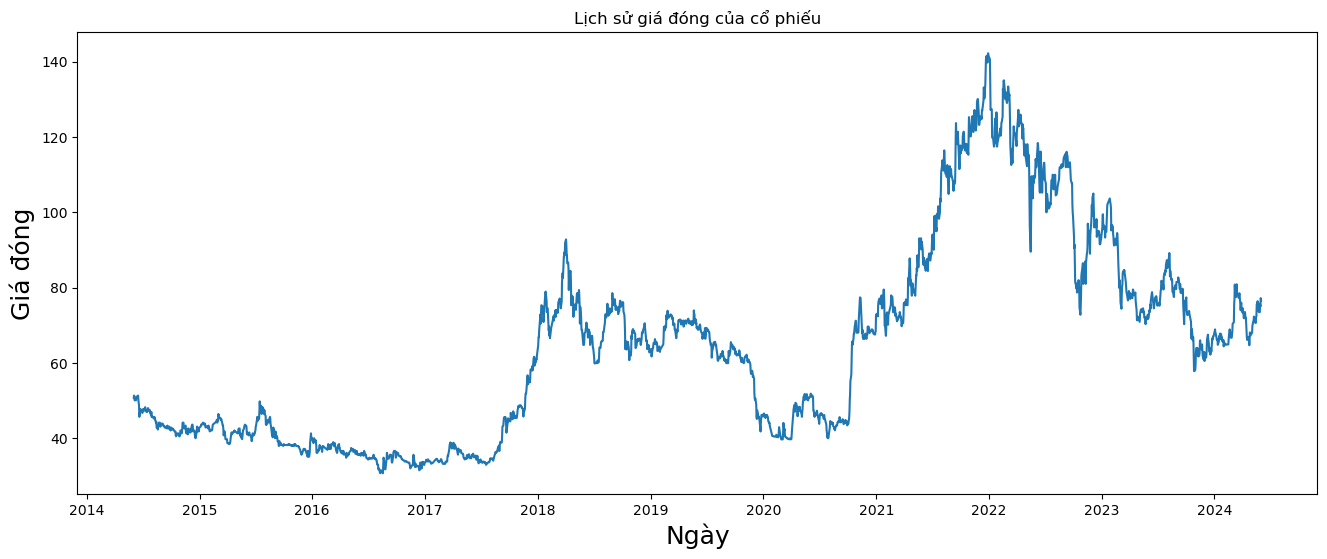

In [5]:
plt.figure(figsize=(16,6))
plt.title('Lịch sử giá đóng của cổ phiếu')
plt.plot(df['Close'])
plt.xlabel('Ngày', fontsize=18)
plt.ylabel('Giá đóng', fontsize=18)
plt.show()

# 3. Phân tích dữ liệu

In [6]:
data1 = df.copy()
#data1 = data1.set_index('time')
# Tính toán các chỉ báo kỹ thuật
data1['SMA_50'] = data1['Close'].rolling(window=50).mean()  # Simple Moving Average (50 ngày)
data1['RSI'] = ta.momentum.RSIIndicator(data1['Close'], window=14).rsi()  # Relative Strength Index (14 ngày)
macd = ta.trend.MACD(data1['Close'])  # MACD
data1['MACD'] = macd.macd()
data1['MACD_Signal'] = macd.macd_signal()

# Xóa các hàng chứa giá trị NaN
data1.dropna(inplace=True)

# Hiển thị dữ liệu
data1

,Open,High,Low,Close,Volume,Ticker,SMA_50,RSI,MACD,MACD_Signal
Time,,,,,,,,,,
2014-08-08,45.15,45.92,44.89,45.66,207960,MSN,47.8958,40.330608,-0.707268,-0.655460
2014-08-11,45.15,45.66,44.63,44.63,416620,MSN,47.7720,33.873816,-0.760341,-0.676436
2014-08-12,44.63,44.89,43.60,44.37,522720,MSN,47.6328,32.461065,-0.813998,-0.703948
2014-08-13,44.37,44.63,43.86,44.12,198470,MSN,47.4938,31.117207,-0.866704,-0.736500
2014-08-14,44.63,44.63,44.12,44.37,317820,MSN,47.3804,34.057177,-0.878178,-0.764835
...,...,...,...,...,...,...,...,...,...,...
2024-05-27,73.50,74.00,72.70,73.50,3881500,MSN,72.7160,53.704832,1.031802,0.715271
2024-05-28,74.20,75.50,73.80,75.50,5100400,MSN,72.6080,59.130687,1.118790,0.795975
2024-05-29,75.70,76.90,75.00,75.00,8003700,MSN,72.5300,57.321939,1.134307,0.863641


In [7]:
# Hàm xác định xu hướng
def determine_trend(row):
    if row['Close'] > row['SMA_50'] and row['RSI'] > 50 and row['MACD'] > row['MACD_Signal']:
        return 'Uptrend'  # Xu hướng tăng
    elif row['Close'] < row['SMA_50'] and row['RSI'] < 50 and row['MACD'] < row['MACD_Signal']:
        return 'Downtrend'  # Xu hướng giảm
    else:
        return 'Sideways'  # Đi ngang

# Áp dụng hàm để xác định xu hướng cho mỗi hàng dữ liệu
data1['Trend'] = data1.apply(determine_trend, axis=1)

data1

,Open,High,Low,Close,Volume,Ticker,SMA_50,RSI,MACD,MACD_Signal,Trend
Time,,,,,,,,,,,
2014-08-08,45.15,45.92,44.89,45.66,207960,MSN,47.8958,40.330608,-0.707268,-0.655460,Downtrend
2014-08-11,45.15,45.66,44.63,44.63,416620,MSN,47.7720,33.873816,-0.760341,-0.676436,Downtrend
2014-08-12,44.63,44.89,43.60,44.37,522720,MSN,47.6328,32.461065,-0.813998,-0.703948,Downtrend
2014-08-13,44.37,44.63,43.86,44.12,198470,MSN,47.4938,31.117207,-0.866704,-0.736500,Downtrend
2014-08-14,44.63,44.63,44.12,44.37,317820,MSN,47.3804,34.057177,-0.878178,-0.764835,Downtrend
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-27,73.50,74.00,72.70,73.50,3881500,MSN,72.7160,53.704832,1.031802,0.715271,Uptrend
2024-05-28,74.20,75.50,73.80,75.50,5100400,MSN,72.6080,59.130687,1.118790,0.795975,Uptrend
2024-05-29,75.70,76.90,75.00,75.00,8003700,MSN,72.5300,57.321939,1.134307,0.863641,Uptrend


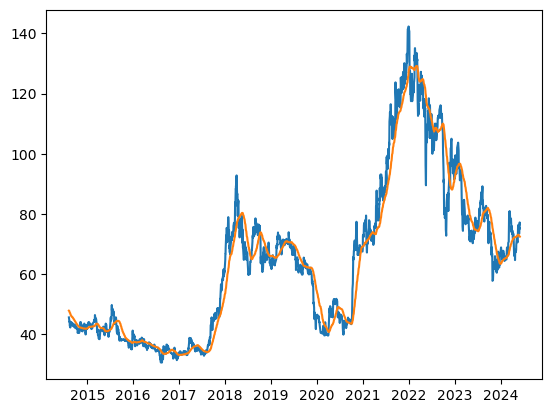

In [8]:
# Biểu đồ giá đóng cửa và SMA
plt.plot(data1.index, data1['Close'], label='Close Price')
plt.plot(data1.index, data1['SMA_50'], label='SMA 50')

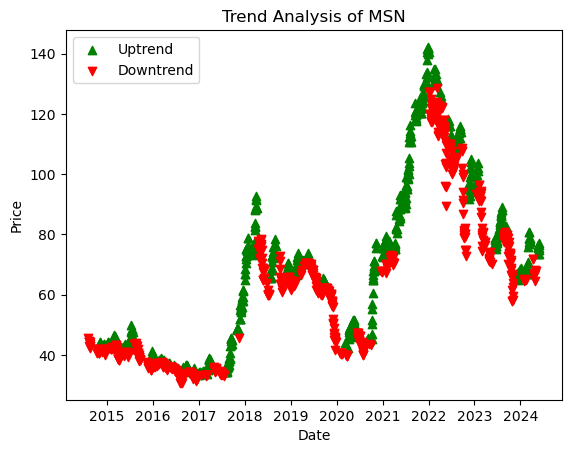

In [9]:
# Đánh dấu xu hướng
uptrend = data1[data1['Trend'] == 'Uptrend']
downtrend = data1[data1['Trend'] == 'Downtrend']

plt.scatter(uptrend.index, uptrend['Close'], label='Uptrend', marker='^', color='g')
plt.scatter(downtrend.index, downtrend['Close'], label='Downtrend', marker='v', color='r')

plt.title(f'Trend Analysis of MSN')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# 4. Linear Regression

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## 4.1. Chia dữ liệu thành các tập Train/Test/Split

In [11]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
train_size = int(len(data1) * 0.6)
test_size = int(len(data1) * 0.2)
train_data = data1[:train_size]
test_data = data1[train_size:train_size + test_size]
prediction_data = data1[train_size + test_size:]

## 4.2. Linear Regression Indicator

In [12]:
# Xác định các đặc trưng và nhãn
features = ['SMA_50', 'RSI', 'MACD', 'MACD_Signal']
target = 'Close'

In [ ]:
# Walk-Forward Validation
def walk_forward_validation(train, test, features, target, prediction_data):
    predictions = []
    history = train.copy()

    for i in range(len(test)):
        model = LinearRegression()
        model.fit(history[features].dropna(), history[target].dropna())
        yhat = model.predict(test[features].iloc[i].values.reshape(1, -1))
        predictions.append(yhat[0])
        history = pd.concat([history, test.iloc[i]], ignore_index=True)

    future_predictions = []
    for i in range(len(prediction_data)):
      model = LinearRegression()
      model.fit(history[features].dropna(), history[target].dropna())
      yhat = model.predict([prediction_data[features].iloc[i]])
      future_predictions.append(yhat[0])
      new_row = prediction_data.iloc[i].copy()
      new_row['Close'] = yhat[0]
      history = pd.concat([history, new_row], ignore_index=True)

    return predictions, future_predictions

# Dự đoán bằng Walk-Forward Validation
predictions, future_predictions = walk_forward_validation(train_data, test_data, features, target, prediction_data)

Mean Squared Error: 6.024720852843272


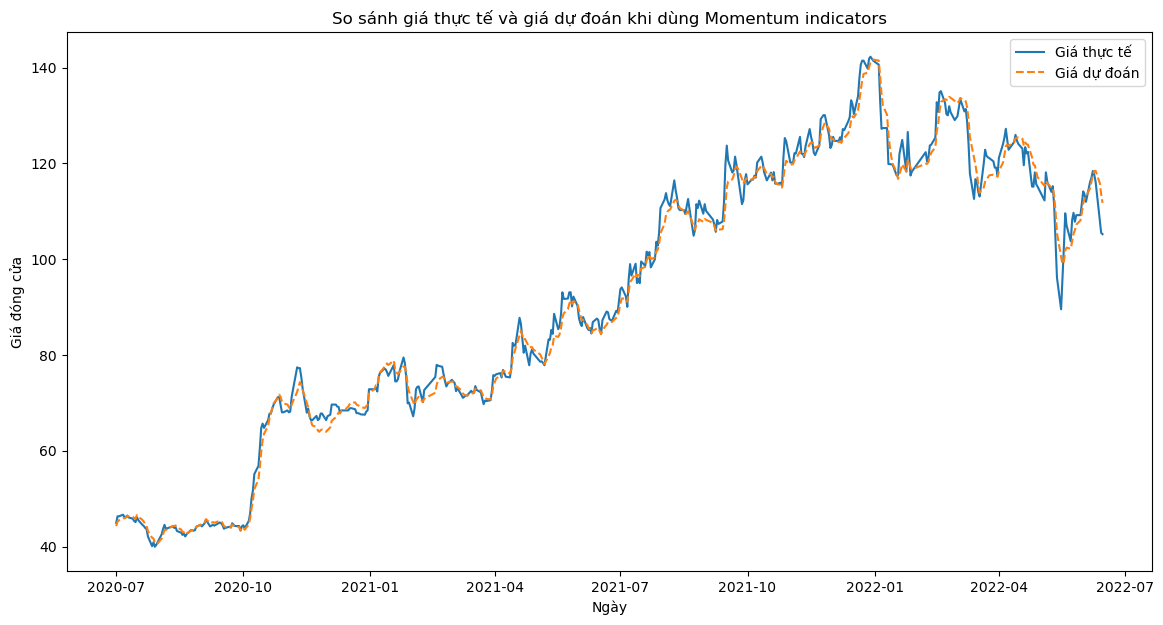

In [14]:
# Đánh giá mô hình
mse = mean_squared_error(test_data[target], predictions)
print(f'Mean Squared Error: {mse}')

# Vẽ biểu đồ so sánh giá thực tế và giá dự đoán
plt.figure(figsize=(14, 7))
plt.plot(test_data.index, test_data[target], label='Giá thực tế')
plt.plot(test_data.index, predictions, label='Giá dự đoán', linestyle='--')
plt.title('So sánh giá thực tế và giá dự đoán khi dùng Momentum indicators')
plt.xlabel('Ngày')
plt.ylabel('Giá đóng cửa')
plt.legend()
plt.show()

In [ ]:
test_data['Predicted'] = predictions
prediction_data['Predicted'] = future_predictions
plt.figure(figsize=(14, 7))

plt.plot(train_data.index, train_data['Close'], label='Train Actual', color='blue')
plt.plot(test_data.index, test_data['Close'], label='Test Actual', color='green')
plt.plot(test_data.index, test_data['Predicted'], label='Test Predicted', linestyle='dashed', color='orange')
plt.plot(prediction_data.index, prediction_data['Close'], label='Prediction Actual', color='purple')
plt.plot(prediction_data.index, prediction_data['Predicted'], label='Prediction Predicted', linestyle='dashed', color='red')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price Prediction')
plt.legend()
plt.show()

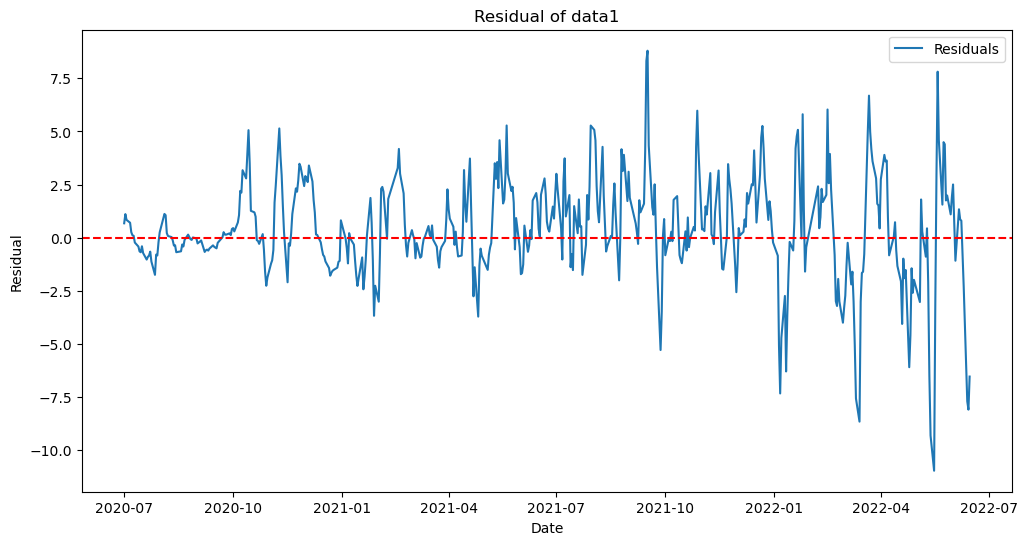

In [16]:
residuals = test_data['Close'] - predictions
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, residuals, label='Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.title('Residual of data1')
plt.legend()
plt.show()

## 4.3. Stochastic Indicator

In [17]:
data2 = df.copy()
data2

,Open,High,Low,Close,Volume,Ticker
Time,,,,,,
2014-06-02,49.78,51.07,49.78,50.82,229020,MSN
2014-06-03,50.56,51.33,50.56,51.33,184340,MSN
2014-06-04,51.59,51.59,50.56,51.07,51080,MSN
2014-06-05,50.82,50.82,50.04,50.04,76150,MSN
2014-06-06,50.82,50.82,49.78,50.30,22360,MSN
...,...,...,...,...,...,...
2024-05-27,73.50,74.00,72.70,73.50,3881500,MSN
2024-05-28,74.20,75.50,73.80,75.50,5100400,MSN
2024-05-29,75.70,76.90,75.00,75.00,8003700,MSN


In [18]:
# Tính toán các chỉ báo kỹ thuật
# data2 = data2.set_index('time')
stoch = ta.momentum.StochasticOscillator(data2['High'], data2['Low'], data2['Close'], window=14)
data2['Stoch_%K'] = stoch.stoch()
data2['Stoch_%D'] = stoch.stoch_signal()

data2['Williams_%R'] = ta.momentum.WilliamsRIndicator(data2['High'], data2['Low'], data2['Close'], lbp=14).williams_r()
data2['StochRSI'] = ta.momentum.StochRSIIndicator(data2['Close'], window=14).stochrsi()

data2.dropna(inplace=True)
data2

,Open,High,Low,Close,Volume,Ticker,Stoch_%K,Stoch_%D,Williams_%R,StochRSI
Time,,,,,,,,,,
2014-07-08,47.99,47.99,47.47,47.99,119560,MSN,53.196347,40.216496,-46.803653,1.000000
2014-07-09,47.99,48.50,47.73,48.24,245550,MSN,66.666667,53.326431,-33.333333,1.000000
2014-07-10,48.24,48.24,47.21,47.73,206000,MSN,62.621359,60.828124,-37.378641,0.752611
2014-07-11,47.73,47.73,46.95,47.21,175810,MSN,28.333333,52.540453,-71.666667,0.522392
2014-07-14,47.21,47.47,46.95,46.95,134220,MSN,13.888889,34.947860,-86.111111,0.413021
...,...,...,...,...,...,...,...,...,...,...
2024-05-27,73.50,74.00,72.70,73.50,3881500,MSN,47.222222,57.870370,-52.777778,0.193401
2024-05-28,74.20,75.50,73.80,75.50,5100400,MSN,75.000000,56.481481,-25.000000,0.510855
2024-05-29,75.70,76.90,75.00,75.00,8003700,MSN,68.055556,63.425926,-31.944444,0.405030


In [ ]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
train_size2 = int(len(data2) * 0.6)
test_size2 = int(len(data2) * 0.2)
train_data2 = data2[:train_size2]
test_data2 = data2[train_size2:train_size2 + test_size2]
prediction_data2 = data2[train_size2 + test_size2:]

features2 = ['Stoch_%K', 'Stoch_%D', 'Williams_%R', 'StochRSI']
target2 = 'Close'

predictions2, future_predictions2 = walk_forward_validation(train_data2, test_data2, features2, target2, prediction_data2)

Mean Squared Error: 6.024720852843272


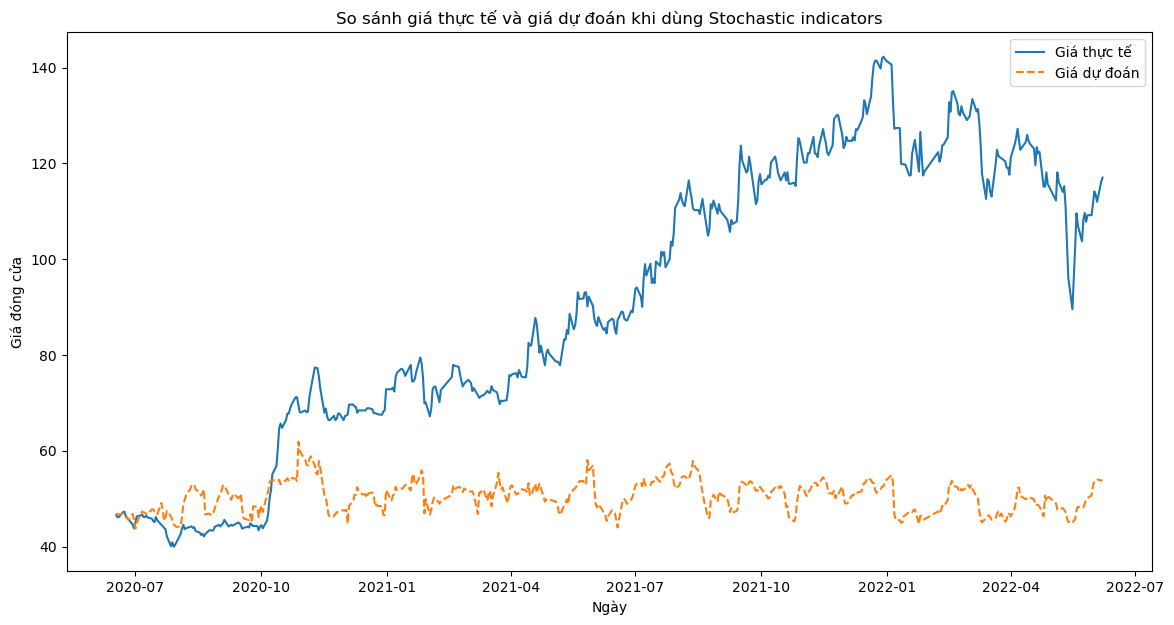

In [20]:
mse2 = mean_squared_error(test_data2[target], predictions2)
print(f'Mean Squared Error: {mse}')

# Vẽ biểu đồ so sánh giá thực tế và giá dự đoán
plt.figure(figsize=(14, 7))
plt.plot(test_data2.index, test_data2[target], label='Giá thực tế')
plt.plot(test_data2.index, predictions2, label='Giá dự đoán', linestyle='--')
plt.title('So sánh giá thực tế và giá dự đoán khi dùng Stochastic indicators')
plt.xlabel('Ngày')
plt.ylabel('Giá đóng cửa')
plt.legend()
plt.show()

In [ ]:
test_data2['Predicted'] = predictions2
prediction_data2['Predicted'] = future_predictions2
plt.figure(figsize=(14, 7))

plt.plot(train_data2.index, train_data2['Close'], label='Train Actual', color='blue')
plt.plot(test_data2.index, test_data2['Close'], label='Test Actual', color='green')
plt.plot(test_data2.index, test_data2['Predicted'], label='Test Predicted', linestyle='dashed', color='orange')
plt.plot(prediction_data.index, prediction_data['Close'], label='Prediction Actual', color='purple')
plt.plot(prediction_data2.index, prediction_data2['Predicted'], label='Prediction Predicted', linestyle='dashed', color='red')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price Prediction')
plt.legend()
plt.show()

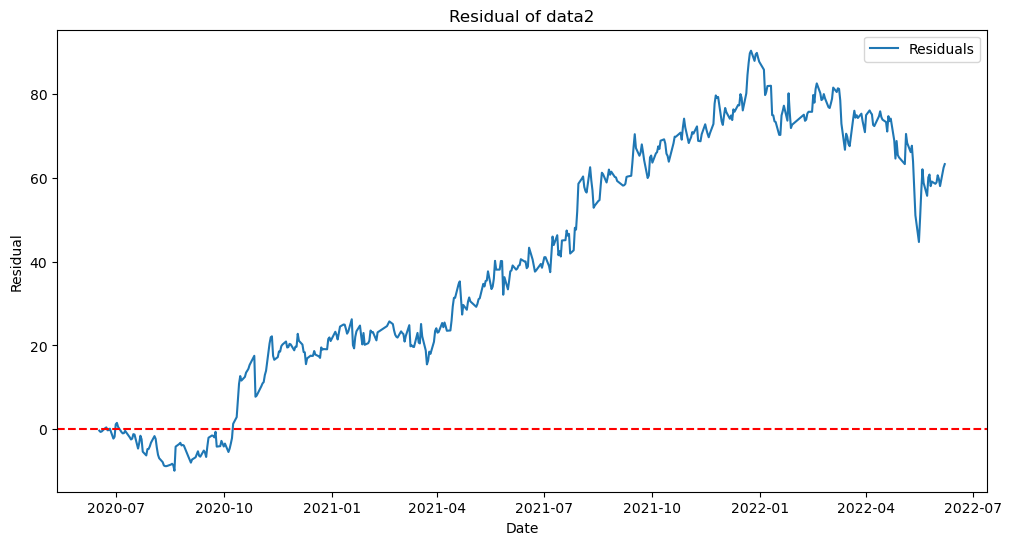

In [22]:
residuals = test_data2['Close'] - predictions2
plt.figure(figsize=(12, 6))
plt.plot(test_data2.index, residuals, label='Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.title('Residual of data2')
plt.legend()
plt.show()

# 5. Deep Learning & LSTM

## 5.1. Tiền xử lý

In [23]:
# Create a new dataframe with only the 'Close column
data = data1[:train_size + test_size].filter(['Close'])
# convert the dataframe to a numpy array
dataset = data.values
# get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .75 ))

# train data chi la length
training_data_len

1470

In [24]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [25]:
# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]

# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print("x_train: ", x_train)
        print("y_train: ", y_train)
        print()

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# x_train.shape
print("Shape of x_train: ", x_train.shape)
print("Shape of y_train: ", y_train.shape)

x_train:  [array([0.13415181, 0.12492159, 0.12259163, 0.12035129, 0.12259163,
       0.1087015 , 0.1087015 , 0.10413119, 0.1087015 , 0.11569137,
       0.12035129, 0.12035129, 0.11569137, 0.11103145, 0.11103145,
       0.11802133, 0.11802133, 0.11802133, 0.11336141, 0.11336141,
       0.11103145, 0.1087015 , 0.1087015 , 0.1087015 , 0.11103145,
       0.1087015 , 0.10646115, 0.1087015 , 0.11336141, 0.10646115,
       0.10646115, 0.1087015 , 0.11103145, 0.10646115, 0.10180124,
       0.10413119, 0.1087015 , 0.10413119, 0.10413119, 0.10646115,
       0.10413119, 0.10413119, 0.10413119, 0.10180124, 0.09947128,
       0.09947128, 0.09947128, 0.09024106, 0.0879111 , 0.09257102,
       0.09490098, 0.09490098, 0.09490098, 0.09490098, 0.0879111 ,
       0.0879111 , 0.09024106, 0.09024106, 0.10180124, 0.10180124])]
y_train:  [0.09490097679003495]

x_train:  [array([0.13415181, 0.12492159, 0.12259163, 0.12035129, 0.12259163,
       0.1087015 , 0.1087015 , 0.10413119, 0.1087015 , 0.11569137,
     

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.summary()


## 5.2. Training

In [27]:
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1410/1410 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - loss: 0.0013


In [28]:
# Create the testing data set
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)



## 5.3. Dự đoán

In [29]:
# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

print(x_test.shape)
print(y_test.shape)

# Get the models predicted price values
predictions_lstm = model.predict(x_test)
predictions_lstm = scaler.inverse_transform(predictions_lstm)
predictions_lstm

(490, 60, 1)
(490, 1)
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


array([[ 43.33189 ],
       [ 42.972626],
       [ 43.17211 ],
       [ 43.575222],
       [ 44.038013],
       [ 44.291695],
       [ 44.374126],
       [ 44.421097],
       [ 44.340897],
       [ 44.163044],
       [ 43.87735 ],
       [ 43.562862],
       [ 43.553204],
       [ 43.547195],
       [ 43.32884 ],
       [ 43.01403 ],
       [ 42.64817 ],
       [ 42.295975],
       [ 41.696507],
       [ 40.68407 ],
       [ 39.915913],
       [ 39.246284],
       [ 38.86596 ],
       [ 38.834187],
       [ 39.337383],
       [ 40.199524],
       [ 41.173145],
       [ 41.73251 ],
       [ 41.971912],
       [ 42.05848 ],
       [ 42.057304],
       [ 41.943333],
       [ 41.844376],
       [ 41.602016],
       [ 41.293564],
       [ 40.937008],
       [ 40.71249 ],
       [ 40.48916 ],
       [ 40.438755],
       [ 40.66538 ],
       [ 40.96471 ],
       [ 41.200047],
       [ 41.361477],
       [ 41.6045  ],
       [ 41.90763 ],
       [ 42.084057],
       [ 42.299152],
       [ 42.6

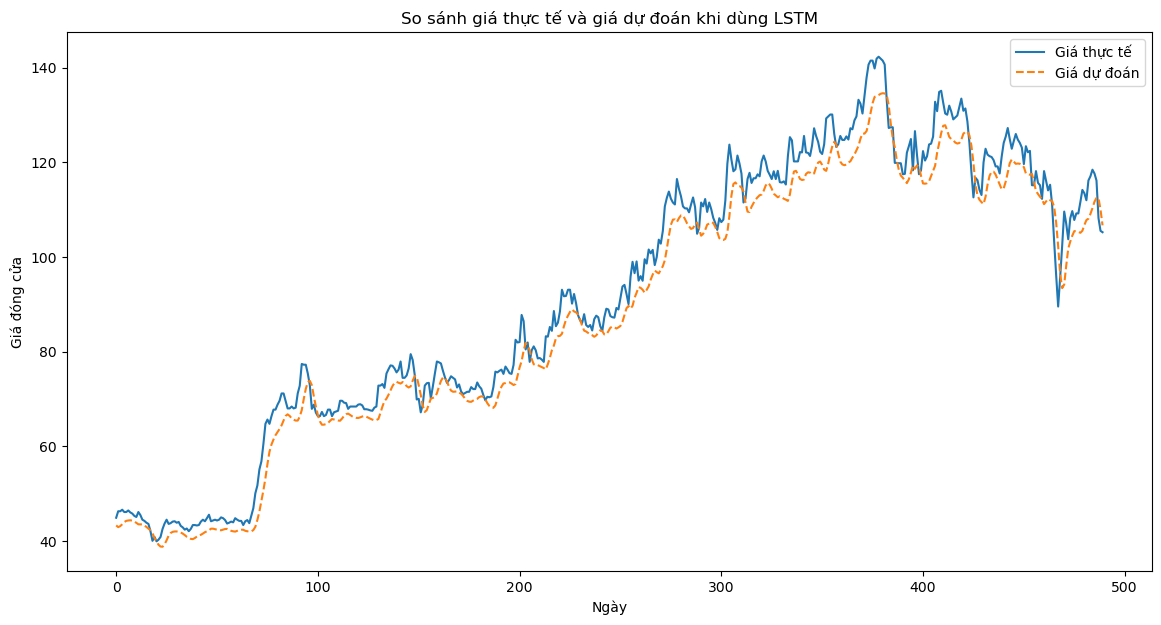

In [30]:
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Giá thực tế')
plt.plot(predictions_lstm, label='Giá dự đoán', linestyle='--')
plt.title('So sánh giá thực tế và giá dự đoán khi dùng LSTM')
plt.xlabel('Ngày')
plt.ylabel('Giá đóng cửa')
plt.legend()
plt.show()

# 6. So sánh kết quả các Model

In [ ]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['LSTM Predictions'] = predictions_lstm
# thêm dự đoán của linear indicator vào dự đoán
valid['Linear Predictions'] = predictions

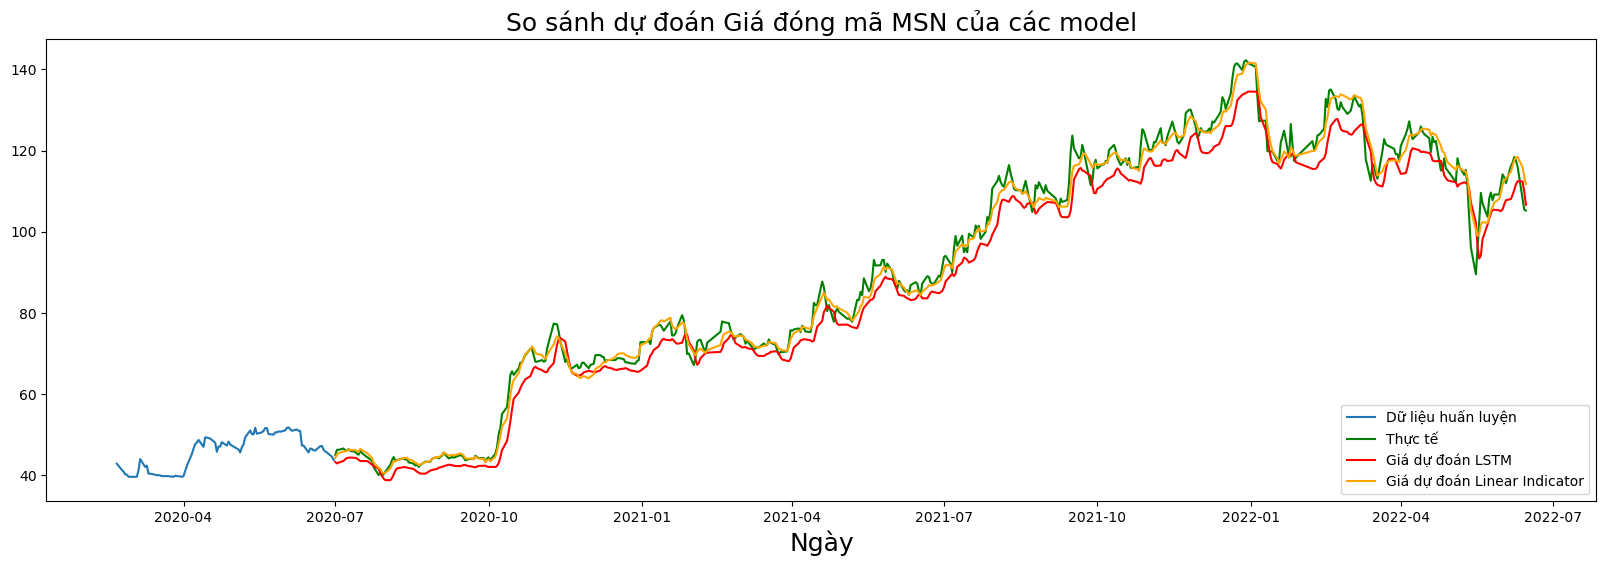

(1470,)


In [32]:
# Visualize the data
plt.figure(figsize=(20,6))
plt.title('So sánh dự đoán Giá đóng mã MSN của các model', fontsize=18)
plt.xlabel('Ngày', fontsize=18)
#plt.ylabel('So sánh dự đoán Giá đóng MSN các mô hình ', fontsize=18)
plt.plot(train['Close'][-90:])
# plt.plot(valid[['Close', 'Predictions', 'Linear Pridict']])

plt.plot(valid['Close'], color='green')
plt.plot(valid['LSTM Predictions'], color='red')
plt.plot(valid['Linear Predictions'], color='orange')
plt.legend(['Dữ liệu huấn luyện', 'Thực tế', 'Giá dự đoán LSTM', 'Giá dự đoán Linear Indicator'], loc='lower right')
plt.show()
print(train['Close'].shape)

In [33]:
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions_lstm - y_test) ** 2)))
rmse_linear = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print("RMSE of LSTM model: ", rmse)
print("RMSE of Linear model: ", rmse_linear)

RMSE of LSTM model:  5.021246648602848
RMSE of Linear model:  40.85791716030041
